In [1]:
#import
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import shap

In [2]:
#Reading dataset
df=pd.read_csv('RDKit.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 419 entries, Cate_name to Yield
dtypes: float64(172), int64(245), object(2)
memory usage: 222.7+ KB


In [3]:
#Preparing

# delete variables with zero variance
Var0Variable = np.where( df.var(axis=0) == 0 )
if len(Var0Variable[0]) == 0:
    print( "There is no variable with zero variance." )
    print( "" )
else:
    print( "There were {0} variables with zero variance".format(len(Var0Variable[0])))
    print( "the number of variable is: {0}".format(Var0Variable[0]) )
    print( "remove them" )
    print( "" )
    #df_var0 = np.delete(df, Var0Variable, 1)    
    df_var0 = df.drop(df.columns[Var0Variable], axis=1)

#removal of columns which data has all 0
def remove_all_zero_col(df):
    df = df.copy()
    for col in df.columns:
        if (df[col] == 0).all():
            df.drop(col, axis=1, inplace=True)
    return df
df_var0 = remove_all_zero_col(df_var0)
df_var0.info()

There were 199 variables with zero variance
the number of variable is: [  9  48  54  62  63  67  80  84 100 107 108 109 111 117 118 119 123 126
 127 128 129 131 132 135 136 137 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 154 155 156 158 160 161 162 165 166 168 169 170 171 172
 173 175 176 177 179 184 185 186 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 217 254 257 260 261 262 266 269 270 271
 272 275 276 278 279 283 284 286 287 288 292 293 295 302 305 306 308 309
 315 316 317 319 325 326 327 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415]
remove them

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 163 entries, Cate_name to Yi

In [4]:
#Building descriptors
X = df_var0.drop(columns=['Yield', 'Cate_name', 'P_name'])

print('---Descriptors---')
print(X.head())

y = pd.DataFrame(df_var0['Yield'],columns=['Yield'])
print('---Objective---')
print(y.head())

---Descriptors---
   Cate_MaxEStateIndex  Cate_MinEStateIndex  Cate_MaxAbsEStateIndex  \
0             8.669259            -0.076389                8.669259   
1             8.669259            -0.076389                8.669259   
2             8.669259            -0.076389                8.669259   
3             8.669259            -0.076389                8.669259   
4             8.850093            -0.068889                8.850093   

   Cate_MinAbsEStateIndex  Cate_qed  Cate_MolWt  Cate_HeavyAtomMolWt  \
0                0.076389  0.490728     110.112              104.064   
1                0.076389  0.490728     110.112              104.064   
2                0.076389  0.490728     110.112              104.064   
3                0.076389  0.490728     110.112              104.064   
4                0.060185  0.513122     124.139              116.075   

   Cate_NumValenceElectrons  Cate_MaxPartialCharge  Cate_MinPartialCharge  \
0                        42               0.1

In [5]:
X=X.astype('float16')
print(X.isnull().any())
X.isnull().values.sum()
X.info()

Cate_MaxEStateIndex         False
Cate_MinEStateIndex         False
Cate_MaxAbsEStateIndex      False
Cate_MinAbsEStateIndex      False
Cate_qed                    False
                            ...  
P_NumAromaticCarbocycles    False
P_NumAromaticRings          False
P_NumHAcceptors             False
P_NumHDonors                False
P_RingCount                 False
Length: 160, dtype: bool
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 160 entries, Cate_MaxEStateIndex to P_RingCount
dtypes: float16(160)
memory usage: 21.4 KB


In [6]:
#storage 
data_r2_train =[]
data_RMSE_train = []
data_MAE_train = []
data_r2_test = []
data_RMSE_test = []
data_MAE_test = []
best_model_parametors = []
data_cv_score = []
cum_imp=pd.Series(index = X.columns)
cum_imp.fillna(0, inplace=True)

#RF_a_X
for i in range(10):
    seed=i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    #autoscaling
    a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1) 

    param_grid = {"max_depth":[2,3,4,5],
                  'n_estimators':[1000,3000,5000]} 
    reg_rf = GridSearchCV(RandomForestRegressor(random_state=0), param_grid=param_grid, cv=5, n_jobs=3)
    reg_rf.fit(a_X_train,y_train['Yield'])
    reg_best = reg_rf.best_estimator_
    y_pred1 = reg_best.predict(a_X_train)
    y_pred2 = reg_best.predict(a_X_test)
            
    #train
    r2_train = metrics.r2_score(y_train, y_pred1)
    RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
    MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    #test
    r2_test = metrics.r2_score(y_test, y_pred2)
    RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
    MAE_test = metrics.mean_absolute_error(y_test, y_pred2)

    parametors = reg_rf.best_params_
    best_model_parametors.append(parametors)

    data_r2_train.append(r2_train)
    data_RMSE_train.append(RMSE_train)
    data_MAE_train.append(MAE_train)
    data_r2_test.append(r2_test)
    data_RMSE_test.append(RMSE_test)
    data_MAE_test.append(MAE_test)
    data_cv_score.append(reg_rf.best_score_)
    
    #cumulative importances 
    importances = pd.Series(reg_best.feature_importances_, index = X.columns)
    cum_imp += importances
    
    print('----------------------')
    print('seed:', seed)
    print("Best Model Parameter:",reg_rf.best_params_)
    print("Best Model Score:",reg_rf.best_score_)
    print('R2_test:', r2_test)
print('R2_train_means:', sum(data_r2_train)/10)
print('CV_score_means:', sum(data_cv_score)/10)
print('R2_test_means:', sum(data_r2_test)/10)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


----------------------
seed: 0
Best Model Parameter: {'max_depth': 2, 'n_estimators': 5000}
Best Model Score: 0.7889278056383505
R2_test: 0.7440209383854202
----------------------
seed: 1
Best Model Parameter: {'max_depth': 4, 'n_estimators': 1000}
Best Model Score: 0.7328516611182074
R2_test: 0.8590456652758444
----------------------
seed: 2
Best Model Parameter: {'max_depth': 2, 'n_estimators': 5000}
Best Model Score: 0.7683073306127713
R2_test: 0.7791157414078504
----------------------
seed: 3
Best Model Parameter: {'max_depth': 2, 'n_estimators': 1000}
Best Model Score: 0.7456114643043619
R2_test: 0.7994510838727983
----------------------
seed: 4
Best Model Parameter: {'max_depth': 5, 'n_estimators': 3000}
Best Model Score: 0.8060714009326579
R2_test: 0.7498502579455311
----------------------
seed: 5
Best Model Parameter: {'max_depth': 5, 'n_estimators': 1000}
Best Model Score: 0.8062258657487529
R2_test: 0.8409964108610797
----------------------
seed: 6
Best Model Parameter: {'max

In [7]:
data_r2_train_pd = pd.DataFrame(data= data_r2_train, columns=['r2_train'])
data_RMSE_train_pd = pd.DataFrame(data=data_RMSE_train, columns=['MSE_train'])
data_MAE_train_pd = pd.DataFrame(data=data_MAE_train, columns=['MAE_train'])
data_r2_test_pd = pd.DataFrame(data=data_r2_test, columns=['r2_test'])
data_RMSE_test_pd = pd.DataFrame(data=data_RMSE_test, columns=['RMSE_test'])
data_MAE_test_pd = pd.DataFrame(data=data_MAE_test, columns=['MAE_test'])
data_cv_score_pd = pd.DataFrame(data=data_cv_score, columns=['cv_score'])
data_parametors = pd.DataFrame([best_model_parametors])
        
data_all = pd.concat([data_r2_train_pd, data_RMSE_train_pd, data_MAE_train_pd, data_r2_test_pd, data_RMSE_test_pd, data_MAE_test_pd, data_cv_score_pd], 
                     axis=1, join='inner')
data_all.loc['mean'] = data_all.mean()
print(data_all)

data_all.to_csv('../../score/RDKit/RF_score.csv')
#data_parametors.to_csv('/Users/nata/Documents/ML/amidation/score/RDKit/RF/parametors.csv')

      r2_train   MSE_train  MAE_train   r2_test   RMSE_test   MAE_test  \
0     0.907300   68.344426   5.446871  0.744021  334.807843  11.200841   
1     0.952777   42.704305   4.080219  0.859046  136.563336   7.758797   
2     0.886535  104.966227   6.546651  0.779116  213.608602   9.343280   
3     0.880502  111.456711   6.657796  0.799451  192.476026   8.545222   
4     0.967236   28.245512   3.034540  0.749850  265.990290  11.022434   
5     0.965067   28.286875   2.884245  0.840996  193.380814   9.562880   
6     0.938293   50.641512   4.462213  0.812718  225.386705   9.750473   
7     0.902156   93.587470   6.189040  0.748542  227.948504   9.960695   
8     0.892798   94.350433   5.732564  0.763671  233.549183  11.323218   
9     0.862635  139.211900   7.875741  0.869418   92.015809   6.000017   
mean  0.915530   76.179537   5.290988  0.796683  211.572711   9.446786   

      cv_score  
0     0.788928  
1     0.732852  
2     0.768307  
3     0.745611  
4     0.806071  
5     0.8

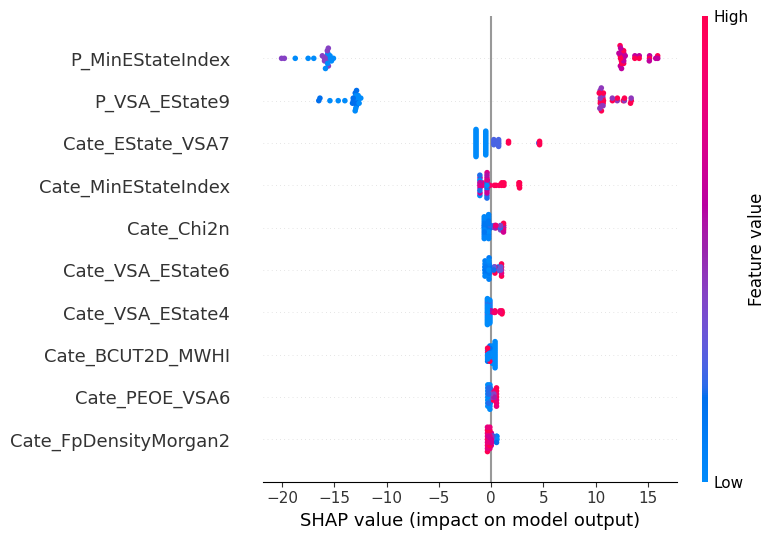

In [10]:
#shap
explainer = shap.TreeExplainer(reg_best)
shap_values = explainer.shap_values(X=a_X_train)
shap.summary_plot(shap_values, a_X_train,max_display=10)

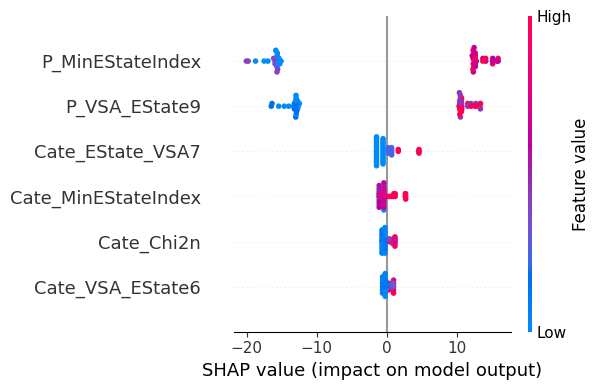

In [11]:
shap.summary_plot(shap_values, X_train,max_display=6, plot_size=(6,4))